## Interest Rate Models Assignment 07
### Weihao Li, Xinlu Xiao

In [20]:
# import packages
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep, splint
from scipy.stats import norm
import time
import matplotlib.pyplot as plt

In [2]:
# Curve class

class Curve():
    def __init__(self, in_k, in_fi):
        '''
        in_k: knot points
        in_fi: knot values
        '''
        self._k  = in_k
        self._fi = in_fi
        self.tck = splrep(self._k, self._fi) 
        
    # calculate the OIS and LIBOR instantaneous rate
    def instantaneous_rate(self, in_time):
        '''
        in_time: evaluated point
        '''
        return splev(in_time,self.tck)
    
    # calculate the derivitive of the curve
    def dev(self,in_time,d):
        '''
        in_time: evaluated point
        d: derivative degree
        '''
        return splev(in_time,self.tck,der = d)
                     
    # calculate the discount factor
    def disc_factor(self, start_time, end_time):
        return exp(-splint(start_time, end_time, self.tck))
                     
    # calculate the forward rate
    def forward_rate(self, start_time, end_time):
        return (exp(splint(start_time,end_time,self.tck))-1)/(end_time-start_time)

In [3]:
class spectual_decomposition:
    def __init__(self,dt,time_point):
        """
        dt        : time interval
        time_point: discritized points
        """
        self.cov = np.zeros((time_point,time_point))
        self.time_point = time_point
        self.dt         = dt
        
        for i in range(time_point):
            for j in range(time_point):
                self.cov[i][j] = (min(i,j) + 1)*dt
        self.eigen_val, self.eigen_vec = np.linalg.eig(self.cov)
        
    def generate_brownian(self):
        """
        calculate a bronian path
        
        """
        normals = np.random.randn(self.time_point)
       
        self.w_t = np.sum(np.sqrt(self.eigen_val)*normals*self.eigen_vec,axis = 1)
        
        
        
        self.w_t = np.insert(0.0,1,self.w_t)
        self.dw_t= np.diff(self.w_t)
        
    def get_dw_t(self):
        """
        return(pop) d_wt
        """
        val = self.dw_t[0]
        self.dw_t = self.dw_t[1:]
        return val
        

In [4]:
class three_month_lmm:
    def __init__(self,set_t,steps,mut_t,libor_init,frozen = False):
        """
        set_t     : spot to settle time
        step      : how many steos to descritize set_t
        mut_t     : settel to maturity time
        libor_init: initialized value for libor simulation
        frozen    : use frozen or not
        """
        self.set_t      = set_t
        self.periods    = mut_t*4
        self.steps      = steps
        self.dt         = 1.0/(steps*1.0)
        self.vol        = 0.0085
        self.libor      = np.zeros((self.periods,steps+1))
        self.libor[:,0] = libor_init
        self.interval   = np.array([0.25*i for i in range(mut_t)])
        self.frozen     =  frozen
        self.rand_gen   = spectual_decomposition(self.dt,self.steps)
    def simulate(self):
        """
        silulate paths for libor forward
        """
        self.rand_gen.generate_brownian()
        for i in range(self.steps):
            d_w = self.rand_gen.get_dw_t()
            for j in range(self.periods):
                increment          =  ( self.drift(j,i)*self.dt + self.vol*d_w)
                self.libor[j][i+1]= max(self.libor[j][i] + increment,0)
        return self.libor[:,-1]          
    
    def drift(self,j,time):
        """
        Calculate drift
        """
        drift = 0
        if self.frozen == True:
            for i in range(j,self.periods):
                drift -= 0.25 *self.vol*self.vol/(1 +0.25* self.libor[i][0])
        else:
            for i in range(j,self.periods):
                if time >0:
                    drift -= 0.25 *self.vol*self.vol/(1 +0.25* self.libor[i][time-1])
                else:
                    drift -= 0.25 *self.vol*self.vol/(1 +0.25* self.libor[i][time])
        return drift      

In [5]:
class swaption():
    def __init__(self,libor_market,libor_curve, f_freq = 2.0,  f_strike = 0.03872):
        """
        initialized swapion class
        
        """
        self.libor_market = libor_market
        self.libor_curve  = libor_curve  
        self.f_freq       = f_freq
        self.f_maturity   = libor_market.periods/4
        self.vol          = libor_market.vol
        self.f_strike     = f_strike
        self.frozen       = libor_market.frozen       
    
    def simulate(self, start_year,i_MC):
        """
        calculate price of the swaption
        start_year : spot to settle
        i_MC       : number of path
        """
        tmp_value = 0.0
        fixed_tenor = 1.0/self.f_freq
        for i in range(i_MC):
            libor_forward = self.libor_market.simulate()
            
            # fixed leg
            maturity = self.f_maturity
            fixed_ = 0.0
            while maturity > 0:
                fixed_   += fixed_tenor * self.f_strike * \
                self.libor_curve.disc_factor(start_year, maturity+1)
                maturity -= fixed_tenor
    
            # floating leg
            maturity = self.f_maturity
            float_ = 0.0
            while maturity > 0:
                float_   += 0.25 * libor_forward[int(maturity/0.25)-1]*\
                self.libor_curve.disc_factor(start_year,maturity+1)
                maturity -= .25 
    
            value_ = (fixed_ - float_)
            tmp_value += max(value_,0)
    
        simulated_value = tmp_value*self.libor_curve.disc_factor(0,start_year)/i_MC
        return simulated_value   

In [6]:
#initialize curves
set_t = 1
steps = 300
mut_t = 10
# curbe knots and the libor value calculated from the first homework
knots_test = [-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,5.0,7.0,10.0,15.0,20.0,25.0,31.0,32.0,33.0,34.0,35.0]
libor_value = [ 0.00948221,  0.01414217, -0.00916129,  0.00544859,  0.00697146,\
                0.00788897,  0.01306847,  0.02447046,  0.03070799,  0.03350761,\
                0.03243098,  0.02976297,  0.0296695 ,  0.02928756,  0.02442423,\
                0.00629273,  0.01080152,  0.00989981]

#libor curve
libor = Curve(knots_test,libor_value)

#initialized 
libor_init = np.array([libor.forward_rate(1+i*0.25, 1+(i+1)*0.25 )\
                          for i in range(40)])



In [8]:
"""
In the case of No Frozen

"""
lmm_model = three_month_lmm(set_t,steps,mut_t,libor_init,frozen = False)
# create swaption object
swaption1 = swaption(lmm_model,libor)
# start from 1Y into 10Y, 2000 simulated path
start = time.time()
swap_nofrozen_2000 = swaption1.simulate(1,2000)
no_frozen_time = (time.time()-start)
# start from 1Y into 10Y, 5000 simulated path
swap_nofrozen_5000 = swaption1.simulate(1,5000)

In [9]:
"""
In the case of Frozen

"""

lmm_model = three_month_lmm(set_t,steps,mut_t,libor_init,frozen = True)

# create swaption object
swaption1 = swaption(lmm_model,libor)
# start from 1Y into 10Y, 2000 simulated path
start = time.time()
swap_frozen_2000 = swaption1.simulate(1,2000)
no_frozen_time = (time.time()-start)
# start from 1Y into 10Y, 5000 simulated path
swap_frozen_5000 = swaption1.simulate(1,5000)

In [18]:
"""

The Final Result

"""

print("After 2000 simulation,taking time ,",no_frozen_time,"s")
print("the price determined by frozen method is ", swap_frozen_2000)
print("the price determined by no frozen method is ", swap_nofrozen_2000)


print("In 5000 Iteration")
print("the price determined by frozen method is ", swap_frozen_5000)
print("the price determined by no frozen method is ", swap_nofrozen_5000)



After 2000 simulation,taking time , 498.38942790031433 s
the price determined by frozen method is  0.134209878402
the price determined by no frozen method is  0.135324987999
In 5000 Iteration
the price determined by frozen method is  0.134379741418
the price determined by no frozen method is  0.135277061047


In [19]:
print("The no-frozen method give a better accuracy,\
        the second accurate is the 5000 iteration frozen mathod,\
        the 2000 simulated frozen one is most inaccurate")

The no-frozen method give a better accuracy,        the second accurate is the 5000 iteration frozen mathod,        the 2000 simulated frozen one is most inaccurate


/home/liweihao/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


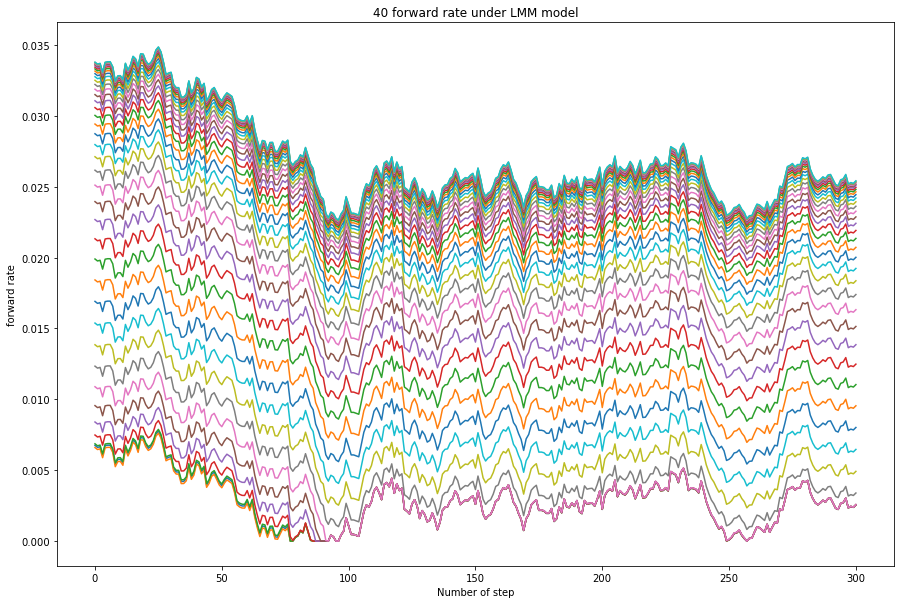

In [29]:
"""
Finally, Let's have a look at what one simulated LLM model prediction is like

"""

fig = plt.figure(figsize=(15,10))

plt.plot( lmm_model.libor.T)

plt.legend()
plt.xlabel("Number of step")
plt.ylabel("forward rate")
plt.title("40 forward rate under LMM model")

plt.show()